In [70]:
from omegaconf import OmegaConf
import wandb
import sys
sys.path.append("../src/")
from data import train_valid_testloader_from_pc, LogTransform, NonTransform, StandardScaler, MinMaxScaler, PowerTransformer, dataloader_from_pc
from model import AEDist, VAEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle
import pandas as pd
from metrics import mAP, computeKNNmAP
import os
from data import train_valid_loader_from_pc, LogTransform, NonTransform, StandardScaler, MinMaxScaler, PowerTransformer
from model import AEDist
import numpy as np
import scipy.sparse
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from procrustes import Procrustes
import pickle
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import yaml
import glob
import matplotlib.ticker as mticker



In [84]:

# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
# sweep_id = "cnpdtv5t"
sweep_id = '4fvcno8c'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

# List all runs in the sweep
run_names = [run.name for run in sweep.runs]

print("Run names in the sweep:", run_names)


Run names in the sweep: ['scarlet-sweep-38', 'apricot-sweep-37', 'neat-sweep-36', 'visionary-sweep-40', 'apricot-sweep-39', 'sparkling-sweep-32', 'light-sweep-33', 'valiant-sweep-34', 'pleasant-sweep-35', 'swift-sweep-31', 'peach-sweep-28', 'valiant-sweep-29', 'atomic-sweep-30', 'rose-sweep-27', 'feasible-sweep-23', 'misty-sweep-26', 'classic-sweep-25', 'fluent-sweep-24', 'proud-sweep-22', 'lively-sweep-21', 'glorious-sweep-17', 'swift-sweep-20', 'chocolate-sweep-19', 'upbeat-sweep-18', 'faithful-sweep-16', 'bright-sweep-14', 'stellar-sweep-13', 'cosmic-sweep-15', 'fallen-sweep-2', 'astral-sweep-6', 'charmed-sweep-8', 'usual-sweep-3', 'fragrant-sweep-11', 'still-sweep-10', 'good-sweep-9', 'flowing-sweep-4', 'fluent-sweep-5', 'warm-sweep-7', 'warm-sweep-12', 'spring-sweep-1']


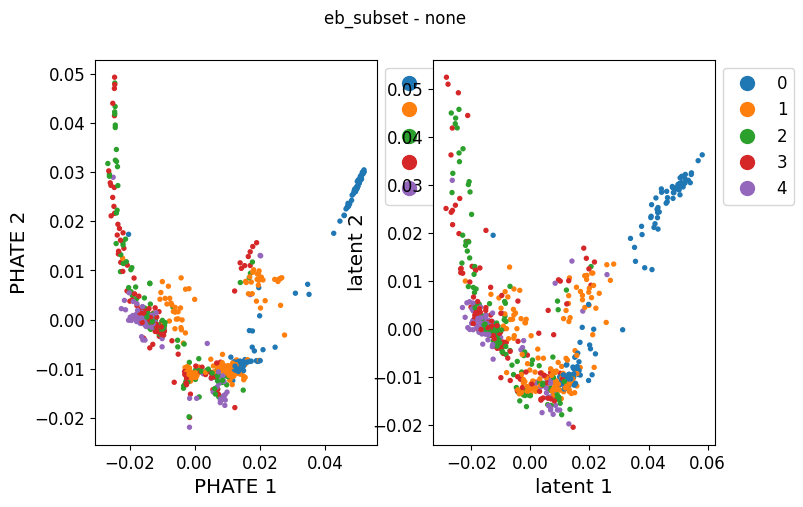

In [85]:
res_list = []
for run in sweep.runs:
    cfg = OmegaConf.create(run.config)
    if cfg.data.preprocess == 'none' and cfg.data.name == 'eb_subset' and cfg.model.dist_reconstr_weights == [0.9, 0.1, 0] and cfg.model.type=='ae':
        folder_path = "../src/wandb/"
        folder_list = glob.glob(f"{folder_path}*{run.id}*")
        ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
        ckpt_path = ckpt_files[0]
        ## Now only supports npz file for simplicity.
        data_path = os.path.join(cfg.data.root, cfg.data.name + "_all" + cfg.data.filetype)
        data = np.load(data_path, allow_pickle=True)
        # sanity check the data is not empty
        assert 'data' in data.files and 'phate' in data.files and 'colors' in data.files and 'dist' in data.files, "Some required files are missing in the 'data' variable."
        X = data['data']
        phate_coords = data['phate']
        colors = data['colors']
        dist = data['dist']
        assert X.shape[0] == phate_coords.shape[0] == colors.shape[0] == dist.shape[0], "The number of cells in the data, phate, and colors variables do not match."
        emb_dim = phate_coords.shape[1]

        if cfg.training.match_potential:
            phate_D = dist
        else:
            phate_D = squareform(pdist(phate_coords))

        preprocessor_dict = {
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
            'power': PowerTransformer(),
            'log': LogTransform(),
            'none': NonTransform()
        }
        pp = preprocessor_dict[cfg.data.preprocess]
        shapes = phate_D.shape
        phate_D = pp.fit_transform(phate_D.reshape(-1,1)).reshape(shapes)
        allloader = dataloader_from_pc(
            X, # <---- Pointcloud
            phate_D, # <---- Distance matrix to match
            batch_size=X.shape[0],
            shuffle=False,)
        train_sample = next(iter(allloader))

        activation_dict = {
            'relu': torch.nn.ReLU(),
            'leaky_relu': torch.nn.LeakyReLU(),
            'sigmoid': torch.nn.Sigmoid()
        }

        activation_fn = activation_dict[cfg.model.activation]
        if cfg.model.type == 'ae':
            model = AEDist.load_from_checkpoint(
                checkpoint_path=ckpt_path,
                dim=train_sample['x'].shape[1],
                emb_dim=emb_dim,
                layer_widths=cfg.model.layer_widths,
                activation_fn=activation_fn,
                dist_reconstr_weights=cfg.model.dist_reconstr_weights,
                pp=pp,
                lr=cfg.model.lr,
                dist_recon_topk_coords=cfg.model.dist_recon_topk_coords,
            )
        elif cfg.model.type == 'vae':
            model = VAEDist.load_from_checkpoint(
                checkpoint_path=ckpt_path,
                dim=train_sample['x'].shape[1],
                emb_dim=emb_dim,
                layer_widths=cfg.model.layer_widths,
                activation_fn=activation_fn,
                dist_reconstr_weights=cfg.model.dist_reconstr_weights,
                kl_weight=cfg.model.kl_weight,
                pp=pp,
                lr=cfg.model.lr,
                dist_recon_topk_coords=cfg.model.dist_recon_topk_coords,
            ) 
        x_all = next(iter(allloader))['x']
        x_pred, z_pred = model(x_all)
        x_pred = x_pred.detach().cpu().numpy()
        z_pred = z_pred.detach().cpu().numpy()
        data_all = data
        data_path_train = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
        train_mask = data_all['is_train']
        test_mask = ~data_all['is_train']
        procrustes = Procrustes()
        phate_proc_train, z_hat, disparity = procrustes.fit_transform(data_all['phate'][train_mask], z_pred[train_mask])
        zhat_all = procrustes.transform(z_pred)
        dist_pred = squareform(pdist(zhat_all))
        dist_true = squareform(pdist(data_all['phate']))
        test_test_mask = test_mask[:,None] * test_mask[None,:]
        test_train_mask = test_mask[:,None] * train_mask[None,:]
        test_all_mask = test_mask[:,None] * np.ones_like(test_mask)
        eps = 1e-10
        dist_mape_test_test = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_test_mask).sum() / test_test_mask.sum()
        dist_mape_test_train = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_train_mask).sum() / test_train_mask.sum()
        dist_mape_test_overall = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_all_mask).sum() / test_all_mask.sum()
        dist_rmse_test_test = np.sqrt(((dist_true - dist_pred)**2 * test_test_mask).sum()/ test_test_mask.sum())
        dist_rmse_test_train = np.sqrt(((dist_true - dist_pred)**2 * test_train_mask).sum() / test_train_mask.sum())
        test_rmse = np.sqrt((data_all['phate'][test_mask] - zhat_all[test_mask])**2).mean()
        res = dict(
            data=cfg.data.name,
            preprocess=cfg.data.preprocess,
            dist_recon_weight = cfg.model.dist_reconstr_weights,
            model_type = cfg.model.type,
            dist_mape_test_test=dist_mape_test_test,
            dist_mape_test_train=dist_mape_test_train,
            dist_mape_test_overall=dist_mape_test_overall,
            dist_rmse_test_test=dist_rmse_test_test,
            dist_rmse_test_train=dist_rmse_test_train,
            test_rmse=test_rmse,
        )
        res_list.append(res)
        fig, ax = plt.subplots(1,2,figsize=(8,5))
        scprep.plot.scatter2d(data_all['phate'][test_mask], c=data_all['colors'][test_mask], ax=ax[0], label_prefix='PHATE ', legend_anchor=(1,1))
        scprep.plot.scatter2d(zhat_all[test_mask], c=data_all['colors'][test_mask], ax=ax[1], label_prefix='latent ', legend_anchor=(1,1))
        plt.suptitle(f"{cfg.data.name} - {cfg.data.preprocess}")
        plt.show()
res_df = pd.DataFrame(res_list)

In [76]:
res_df

,data,preprocess,dist_recon_weight,model_type,dist_mape_test_test,dist_mape_test_train,dist_mape_test_overall,dist_rmse_test_test,dist_rmse_test_train,test_rmse
0,eb_subset,none,"[0.9, 0.1, 0]",ae,0.340986,0.269597,0.283875,0.004525,0.003755,0.00215


In [77]:

# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
# sweep_id = "cnpdtv5t"
sweep_id = 'nbcoi2jr'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

# List all runs in the sweep
run_names = [run.name for run in sweep.runs]

print("Run names in the sweep:", run_names)


Run names in the sweep: ['pretty-sweep-7', 'genial-sweep-10', 'royal-sweep-9', 'ruby-sweep-8', 'divine-sweep-6', 'stellar-sweep-5', 'autumn-sweep-4', 'dry-sweep-3', 'firm-sweep-2', 'usual-sweep-1']


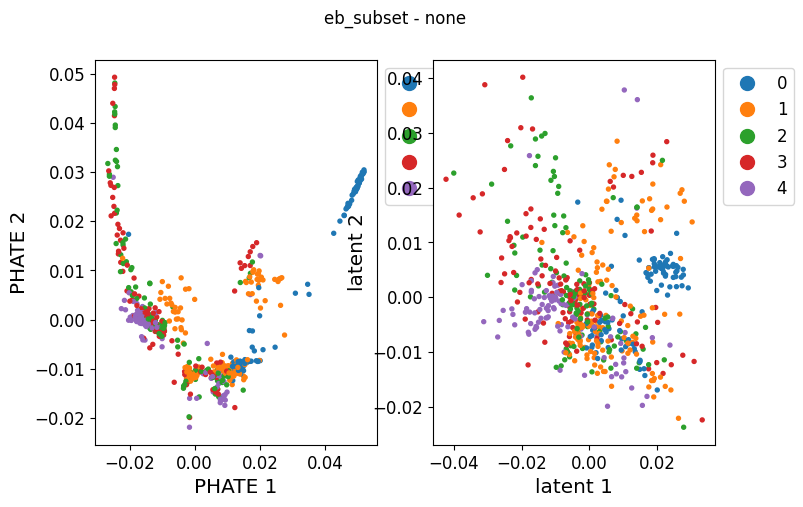

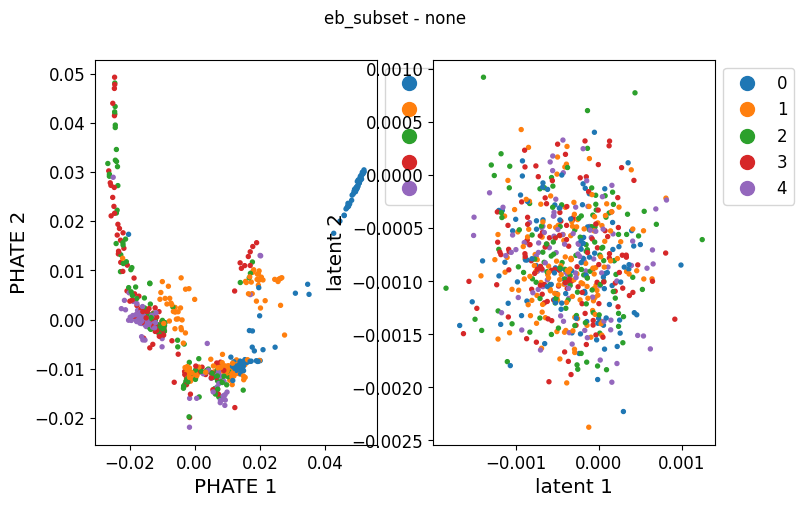

In [78]:
res_list = []
for run in sweep.runs:
    cfg = OmegaConf.create(run.config)
    if cfg.data.preprocess == 'none' and cfg.data.name == 'eb_subset' and cfg.model.dist_reconstr_weights == [0, 1, 0]:
        folder_path = "../src/wandb/"
        folder_list = glob.glob(f"{folder_path}*{run.id}*")
        ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
        ckpt_path = ckpt_files[0]
        ## Now only supports npz file for simplicity.
        data_path = os.path.join(cfg.data.root, cfg.data.name + "_all" + cfg.data.filetype)
        data = np.load(data_path, allow_pickle=True)
        # sanity check the data is not empty
        assert 'data' in data.files and 'phate' in data.files and 'colors' in data.files and 'dist' in data.files, "Some required files are missing in the 'data' variable."
        X = data['data']
        phate_coords = data['phate']
        colors = data['colors']
        dist = data['dist']
        assert X.shape[0] == phate_coords.shape[0] == colors.shape[0] == dist.shape[0], "The number of cells in the data, phate, and colors variables do not match."
        emb_dim = phate_coords.shape[1]

        if cfg.training.match_potential:
            phate_D = dist
        else:
            phate_D = squareform(pdist(phate_coords))

        preprocessor_dict = {
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
            'power': PowerTransformer(),
            'log': LogTransform(),
            'none': NonTransform()
        }
        pp = preprocessor_dict[cfg.data.preprocess]
        shapes = phate_D.shape
        phate_D = pp.fit_transform(phate_D.reshape(-1,1)).reshape(shapes)
        allloader = dataloader_from_pc(
            X, # <---- Pointcloud
            phate_D, # <---- Distance matrix to match
            batch_size=X.shape[0],
            shuffle=False,)
        train_sample = next(iter(allloader))

        activation_dict = {
            'relu': torch.nn.ReLU(),
            'leaky_relu': torch.nn.LeakyReLU(),
            'sigmoid': torch.nn.Sigmoid()
        }

        activation_fn = activation_dict[cfg.model.activation]
        if cfg.model.type == 'ae':
            model = AEDist.load_from_checkpoint(
                checkpoint_path=ckpt_path,
                dim=train_sample['x'].shape[1],
                emb_dim=emb_dim,
                layer_widths=cfg.model.layer_widths,
                activation_fn=activation_fn,
                dist_reconstr_weights=cfg.model.dist_reconstr_weights,
                pp=pp,
                lr=cfg.model.lr,
                dist_recon_topk_coords=cfg.model.dist_recon_topk_coords,
            )
        elif cfg.model.type == 'vae':
            model = VAEDist.load_from_checkpoint(
                checkpoint_path=ckpt_path,
                dim=train_sample['x'].shape[1],
                emb_dim=emb_dim,
                layer_widths=cfg.model.layer_widths,
                activation_fn=activation_fn,
                dist_reconstr_weights=cfg.model.dist_reconstr_weights,
                kl_weight=cfg.model.kl_weight,
                pp=pp,
                lr=cfg.model.lr,
                dist_recon_topk_coords=cfg.model.dist_recon_topk_coords,
            ) 
        x_all = next(iter(allloader))['x']
        x_pred, z_pred = model(x_all)
        x_pred = x_pred.detach().cpu().numpy()
        z_pred = z_pred.detach().cpu().numpy()
        data_all = data
        data_path_train = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
        train_mask = data_all['is_train']
        test_mask = ~data_all['is_train']
        procrustes = Procrustes()
        phate_proc_train, z_hat, disparity = procrustes.fit_transform(data_all['phate'][train_mask], z_pred[train_mask])
        zhat_all = procrustes.transform(z_pred)
        dist_pred = squareform(pdist(zhat_all))
        dist_true = squareform(pdist(data_all['phate']))
        test_test_mask = test_mask[:,None] * test_mask[None,:]
        test_train_mask = test_mask[:,None] * train_mask[None,:]
        eps = 1e-10
        dist_mape_test_test = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_test_mask).sum() / test_test_mask.sum()
        dist_mape_test_train = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_train_mask).sum() / test_train_mask.sum()
        dist_mape_test_overall = (np.abs(dist_true - dist_pred + eps) / (dist_true + eps) * test_all_mask).sum() / test_all_mask.sum()
        dist_rmse_test_test = np.sqrt(((dist_true - dist_pred)**2 * test_test_mask).sum() / test_test_mask.sum())
        dist_rmse_test_train = np.sqrt(((dist_true - dist_pred)**2 * test_train_mask).sum() / test_train_mask.sum())
        test_rmse = np.sqrt((data_all['phate'][test_mask] - zhat_all[test_mask])**2).mean()
        res = dict(
            data=cfg.data.name,
            preprocess=cfg.data.preprocess,
            dist_recon_weight = cfg.model.dist_reconstr_weights,
            model_type = cfg.model.type,
            dist_mape_test_test=dist_mape_test_test,
            dist_mape_test_train=dist_mape_test_train,
            dist_mape_test_overall=dist_mape_test_overall,
            dist_rmse_test_test=dist_rmse_test_test,
            dist_rmse_test_train=dist_rmse_test_train,
            test_rmse=test_rmse,
        )
        res_list.append(res)
        fig, ax = plt.subplots(1,2,figsize=(8,5))
        scprep.plot.scatter2d(data_all['phate'][test_mask], c=data_all['colors'][test_mask], ax=ax[0], label_prefix='PHATE ', legend_anchor=(1,1))
        scprep.plot.scatter2d(zhat_all[test_mask], c=data_all['colors'][test_mask], ax=ax[1], label_prefix='latent ', legend_anchor=(1,1))
        plt.suptitle(f"{cfg.data.name} - {cfg.data.preprocess}")
        plt.show()
res_df2 = pd.DataFrame(res_list)

In [79]:
res_df2

,data,preprocess,dist_recon_weight,model_type,dist_mape_test_test,dist_mape_test_train,dist_mape_test_overall,dist_rmse_test_test,dist_rmse_test_train,test_rmse
0,eb_subset,none,"[0, 1, 0]",ae,0.803488,0.844964,0.836669,0.016500,0.015715,0.007148
1,eb_subset,none,"[0, 1, 0]",vae,0.930369,0.926196,0.927030,0.033181,0.031735,0.012850


In [80]:
res_all = pd.concat([res_df, res_df2])

In [81]:
res_all

,data,preprocess,dist_recon_weight,model_type,dist_mape_test_test,dist_mape_test_train,dist_mape_test_overall,dist_rmse_test_test,dist_rmse_test_train,test_rmse
0,eb_subset,none,"[0.9, 0.1, 0]",ae,0.340986,0.269597,0.283875,0.004525,0.003755,0.002150
0,eb_subset,none,"[0, 1, 0]",ae,0.803488,0.844964,0.836669,0.016500,0.015715,0.007148
1,eb_subset,none,"[0, 1, 0]",vae,0.930369,0.926196,0.927030,0.033181,0.031735,0.012850


In [82]:
res_all['method'] = ['Ours', 'AE', 'VAE']

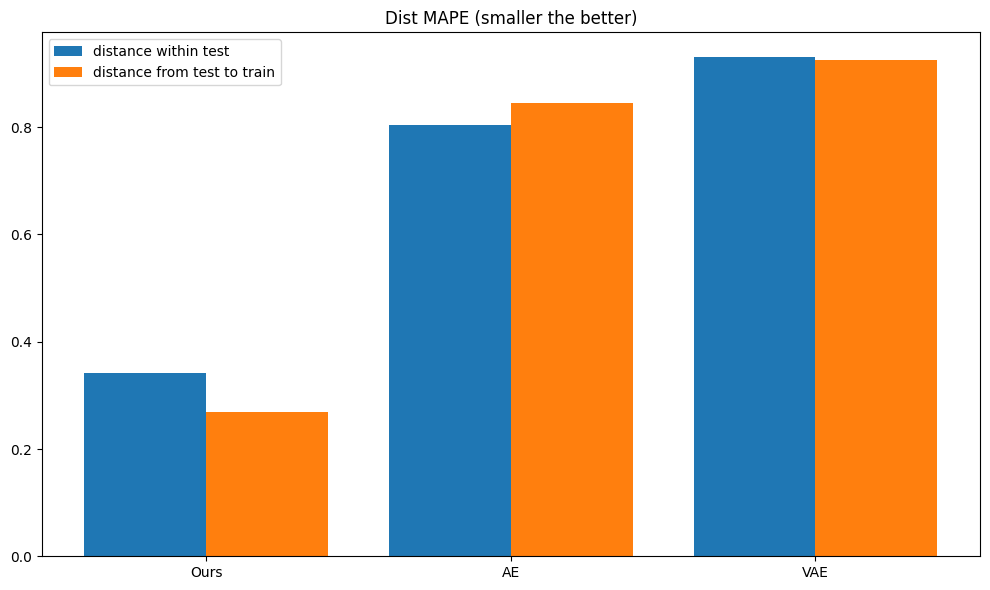

In [83]:
plt.figure(figsize=(10, 6))
# Assuming res_df is your DataFrame
data_subset = res_all
width = 0.4  # width of the bars

# Create a numeric range for x-coordinates
ind = np.arange(len(data_subset))

# Create the bar plots
plt.bar(ind - width/2, data_subset['dist_mape_test_test'], width, label='distance within test')
plt.bar(ind + width/2, data_subset['dist_mape_test_train'], width, label='distance from test to train')

# Set the x-ticks and labels
plt.xticks(ind, data_subset['method'])
plt.xticks(rotation=0)
# plt.ylim(0.006, 0.007)
# plt.ylim(0., 0.016)
plt.title('Dist MAPE (smaller the better)')
plt.legend()
plt.tight_layout()
plt.show()

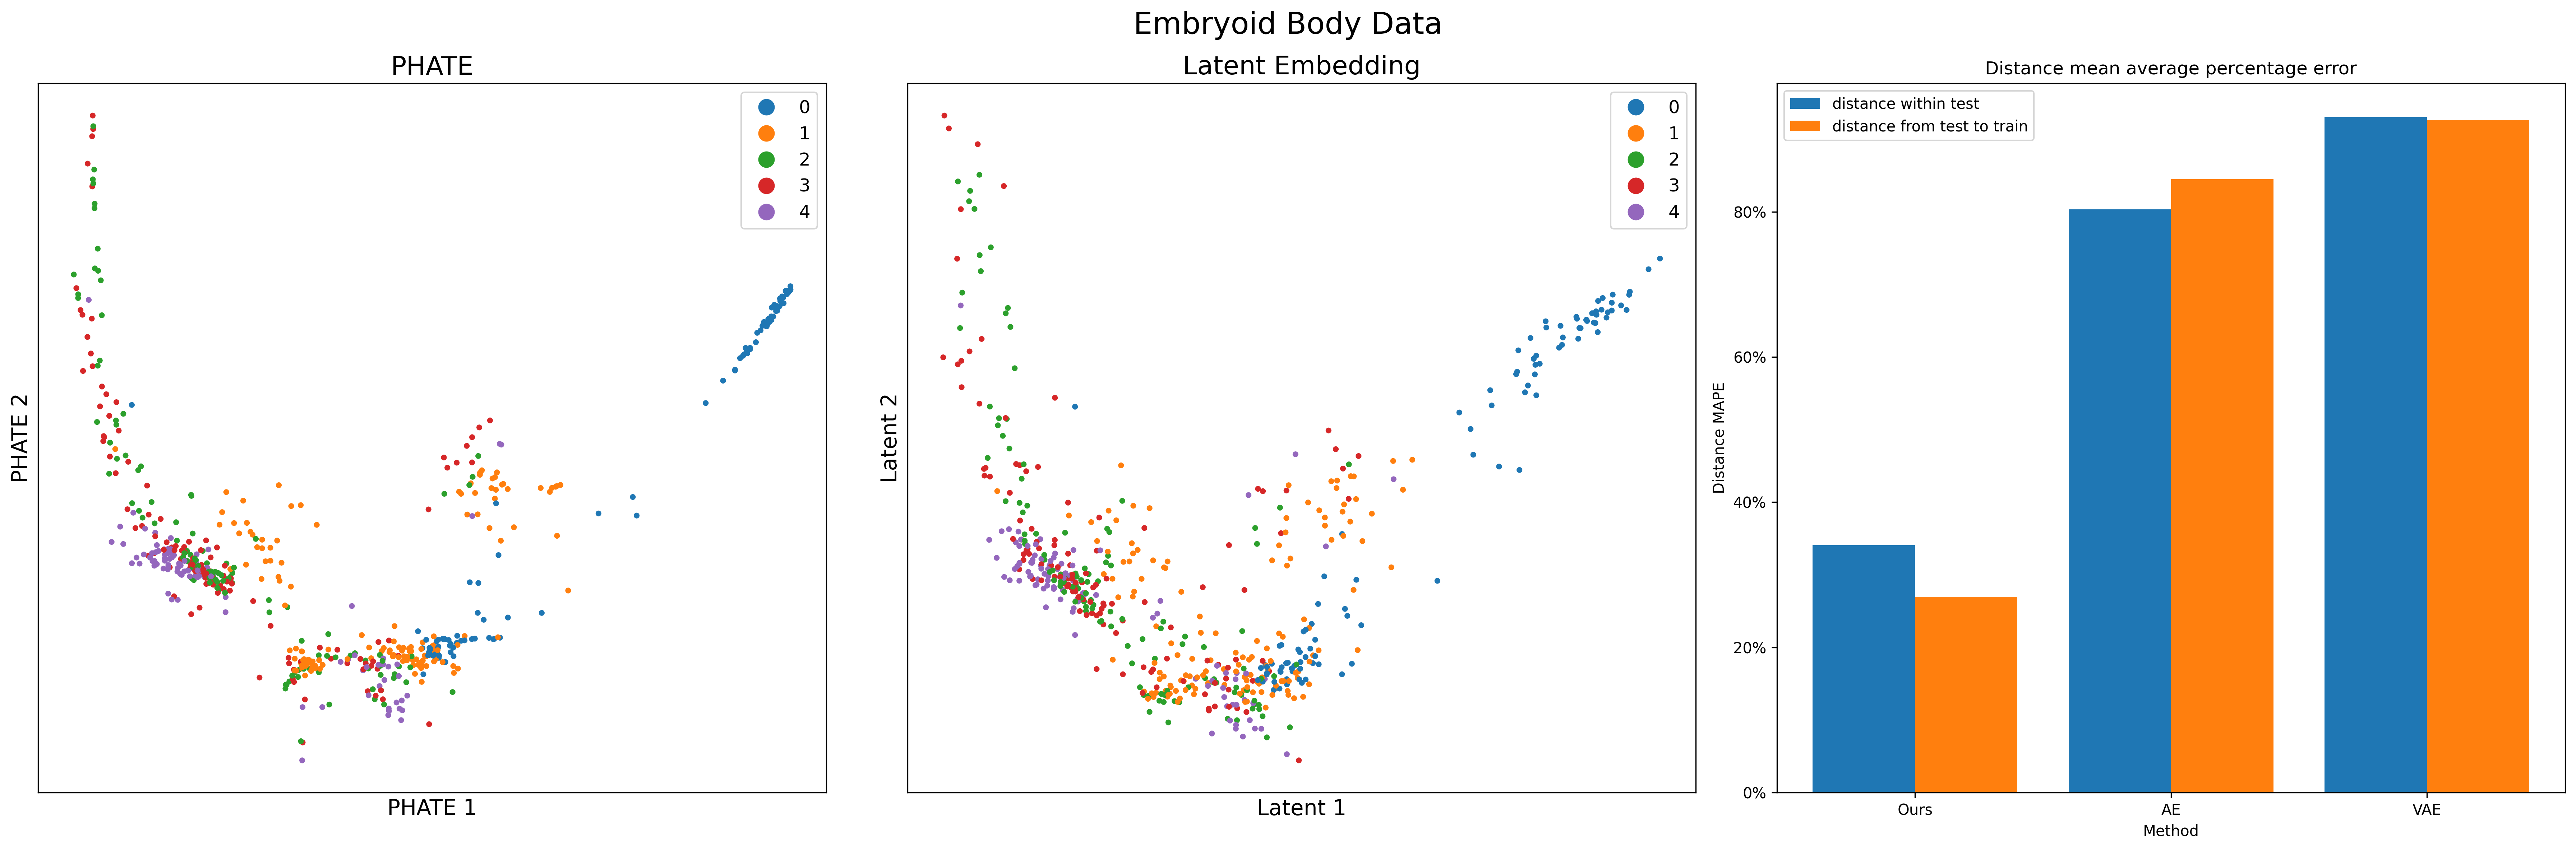

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

# Rest of the code remains the same
scprep.plot.scatter2d(data_all['phate'][test_mask], c=data_all['colors'][test_mask], ax=axes[0], #cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

scprep.plot.scatter2d(zhat_all[test_mask], c=data_all['colors'][test_mask], ax=axes[1], #cmap='Spectral',
                      ticks=False, label_prefix="Latent ", title='Latent Embedding')


data_subset = res_all
width = 0.4  # width of the bars

# Create a numeric range for x-coordinates
ind = np.arange(len(data_subset))

# Create the bar plots
axes[2].bar(ind - width/2, data_subset['dist_mape_test_test'], width, label='distance within test')
axes[2].bar(ind + width/2, data_subset['dist_mape_test_train'], width, label='distance from test to train')

# Set the x-ticks and labels
axes[2].set_xticks(ind, data_subset['method'])
# axes[2].set_xticks(rotation=0)
# axes[2].ylim(0.006, 0.007)
# axes[2].ylim(0., 0.016)
axes[2].set_xlabel('Method')
axes[2].set_ylabel('Distance MAPE')

axes[2].set_title('Distance mean average percentage error')
axes[2].legend()
axes[2].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.suptitle(f"Embryoid Body Data", fontsize=20)

plt.tight_layout()
plt.show()

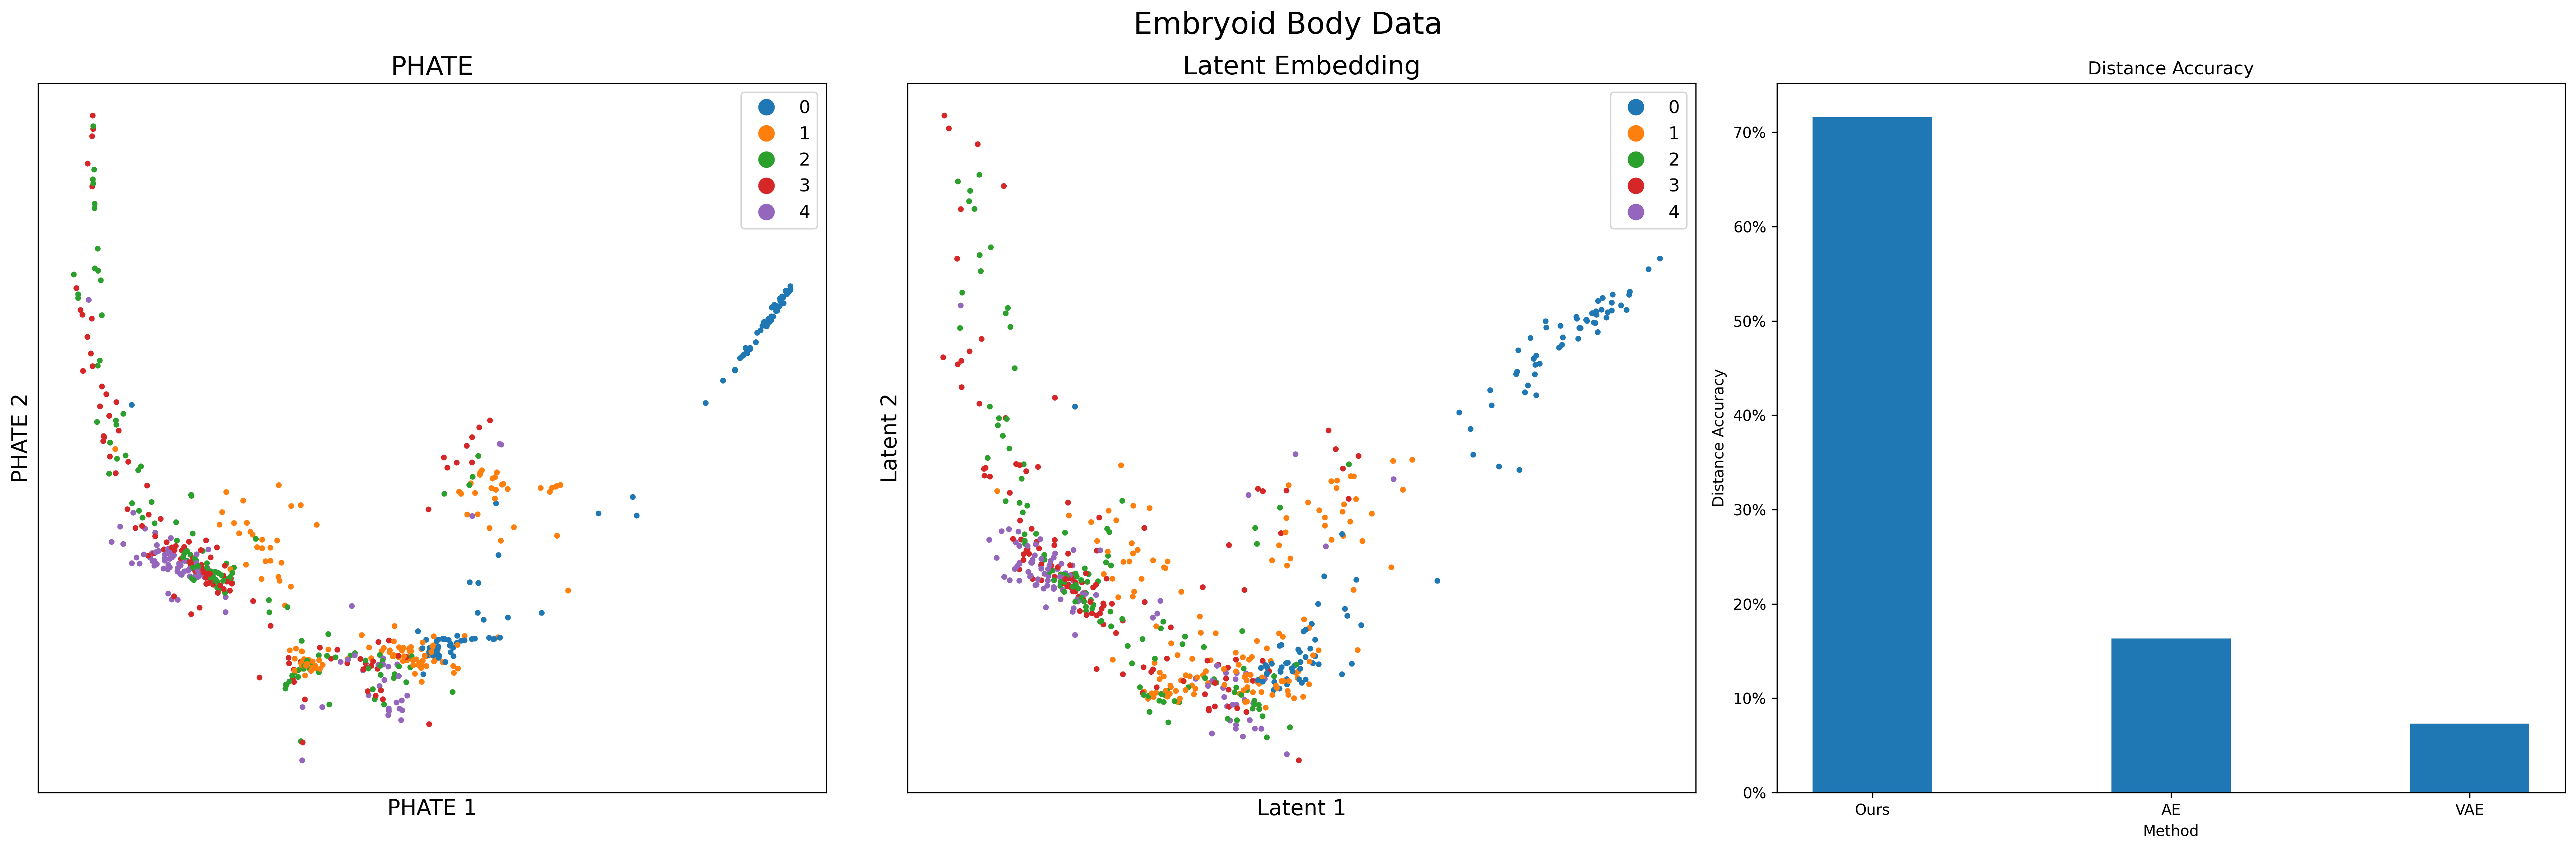

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

# Rest of the code remains the same
scprep.plot.scatter2d(data_all['phate'][test_mask], c=data_all['colors'][test_mask], ax=axes[0], #cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

scprep.plot.scatter2d(zhat_all[test_mask], c=data_all['colors'][test_mask], ax=axes[1], #cmap='Spectral',
                      ticks=False, label_prefix="Latent ", title='Latent Embedding')


data_subset = res_all
width = 0.4  # width of the bars

# Create a numeric range for x-coordinates
# ind = np.arange(len(data_subset))

# Create the bar plots
axes[2].bar(data_subset['method'], 1-data_subset['dist_mape_test_overall'], width, label='distance accuracy')
# axes[2].bar(ind + width/2, data_subset['dist_mape_test_train'], width, label='distance from test to train')

# Set the x-ticks and labels
axes[2].set_xticks(ind, data_subset['method'])
# axes[2].set_xticks(rotation=0)
# axes[2].ylim(0.006, 0.007)
# axes[2].ylim(0., 0.016)
axes[2].set_xlabel('Method')
axes[2].set_ylabel('Distance Accuracy')

axes[2].set_title('Distance Accuracy')
# axes[2].legend()
axes[2].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.suptitle(f"Embryoid Body Data", fontsize=20)

plt.tight_layout()
plt.show()

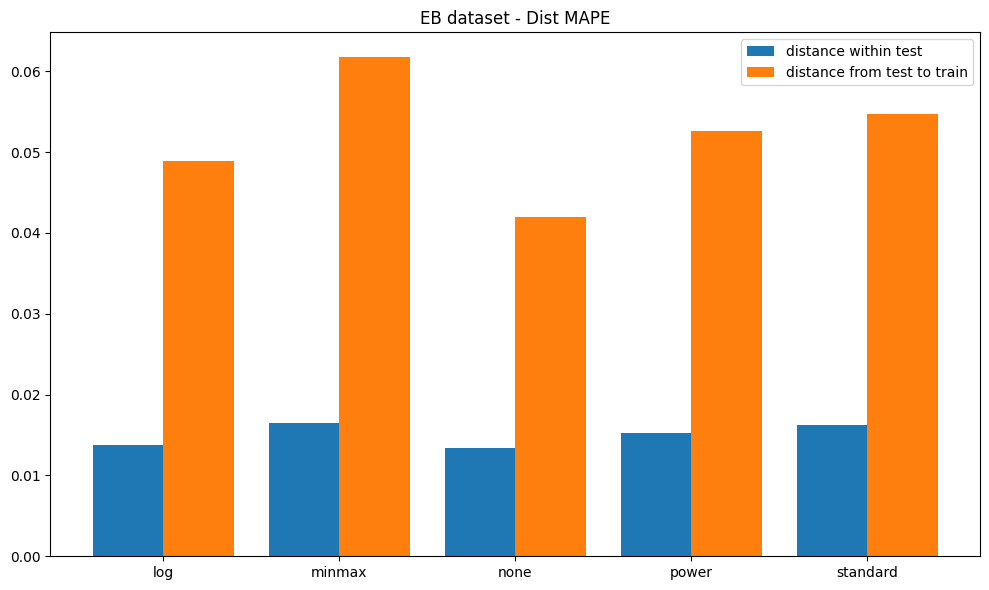

In [121]:
# plt.figure(figsize=(10, 6))
# # Assuming res_df is your DataFrame
# data_subset = res_df[res_df['data'] == 'eb_subset'].sort_values(by='preprocess')
# width = 0.4  # width of the bars

# # Create a numeric range for x-coordinates
# ind = np.arange(len(data_subset))

# # Create the bar plots
# plt.bar(ind - width/2, data_subset['dist_mape_test_test'], width, label='distance within test')
# plt.bar(ind + width/2, data_subset['dist_mape_test_train'], width, label='distance from test to train')

# # Set the x-ticks and labels
# plt.xticks(ind, data_subset['preprocess'])
# plt.xticks(rotation=0)
# # plt.ylim(0.006, 0.007)
# # plt.ylim(0., 0.018)
# plt.legend()
# plt.title('EB dataset - Dist MAPE')
# plt.tight_layout()
# plt.show()

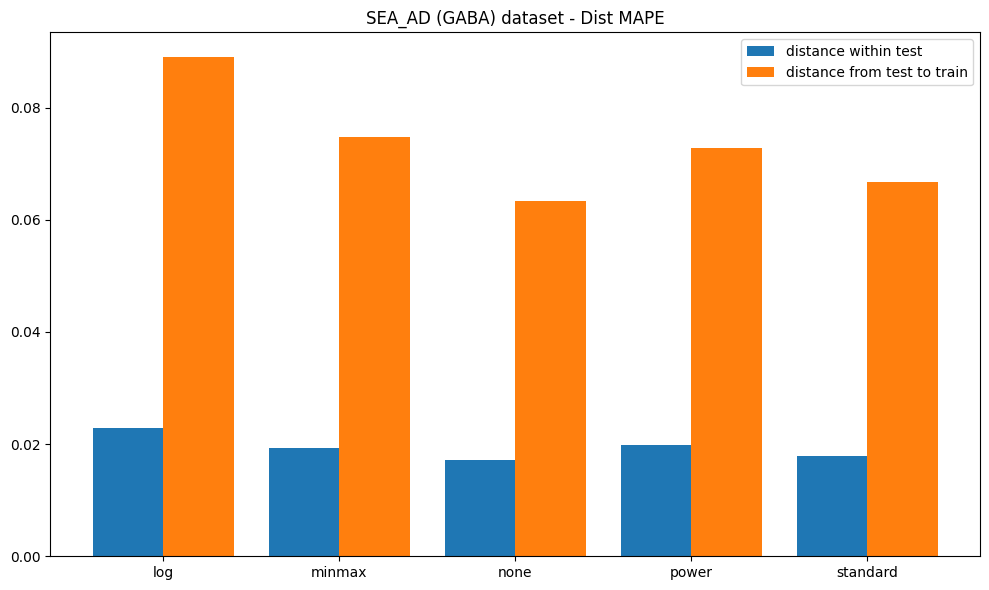

In [123]:
plt.figure(figsize=(10, 6))
# Assuming res_df is your DataFrame
data_subset = res_df[res_df['data'] == 'sea_ad_gaba'].sort_values(by='preprocess')
width = 0.4  # width of the bars

# Create a numeric range for x-coordinates
ind = np.arange(len(data_subset))

# Create the bar plots
plt.bar(ind - width/2, data_subset['dist_mape_test_test'], width, label='distance within test')
plt.bar(ind + width/2, data_subset['dist_mape_test_train'], width, label='distance from test to train')

# Set the x-ticks and labels
plt.xticks(ind, data_subset['preprocess'])
plt.xticks(rotation=0)
# plt.ylim(0.006, 0.007)
# plt.ylim(0., 0.016)
plt.title('SEA_AD (GABA) dataset - Dist MAPE')
plt.legend()
plt.tight_layout()
plt.show()

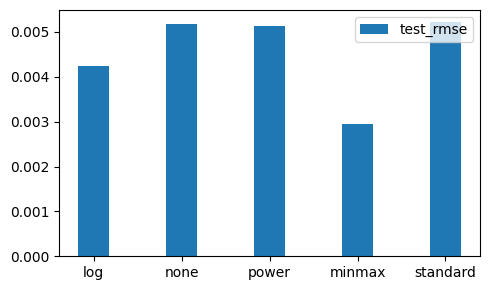

In [113]:
plt.figure(figsize=(5, 3))
# Assuming res_df is your DataFrame
data_subset = res_df[res_df['data'] == 'sea_ad_gaba']
# width = 0.35  # width of the bars

# Create a numeric range for x-coordinates
# ind = np.arange(len(data_subset))

# Create the bar plots
plt.bar(data_subset['preprocess'], data_subset['test_rmse'], width, label='test_rmse')

# Set the x-ticks and labels
plt.xticks(rotation=0)
# plt.ylim(0.006, 0.007)
# plt.ylim(0., 0.016)
plt.legend()
plt.tight_layout()
plt.show()

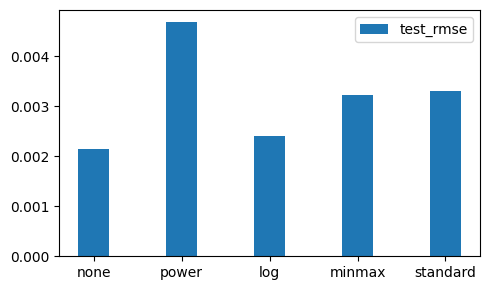

In [114]:
plt.figure(figsize=(5, 3))
# Assuming res_df is your DataFrame
data_subset = res_df[res_df['data'] == 'eb_subset']
# width = 0.35  # width of the bars

# Create a numeric range for x-coordinates
# ind = np.arange(len(data_subset))

# Create the bar plots
plt.bar(data_subset['preprocess'], data_subset['test_rmse'], width, label='test_rmse')

# Set the x-ticks and labels
plt.xticks(rotation=0)
# plt.ylim(0.006, 0.007)
# plt.ylim(0., 0.016)
plt.legend()
plt.tight_layout()
plt.show()